In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
import sys
import time

sys.path.append('../../scripts/')
from prepare import prepare_data

sys.path.append('../../sims/')
from simfrb import make_frb

In [2]:
%load_ext cython

In [64]:
%%cython

import numpy as np
cimport numpy as np
import cython


CONST = 4140e12 # s Hz^2 / (pc / cm^3)


def DM_delay(DM, freq):
    return np.float32(DM * CONST) / freq**2


def phs_sum(np.ndarray[np.complex64_t, ndim=2] d,
            np.ndarray[np.complex64_t, ndim=2] p):
    cdef int i, j
    cdef float complex buf1, buf2
    for i in range(d.shape[0]):
        for j in range(0, d.shape[1], 2):
            buf1 = d[i, j] + d[i, j + 1]
            buf2 = p[i, j] * d[i, j] + p[i, j + 1] * d[i, j + 1]
            d[i, j] = buf1
            d[i, j + 1] = buf2
    return


class FDMT:
    def __init__(self, freqs, times, maxDM=500, dtype='float32', cdtype='complex64'):
        self.cache = {}
        self.dtype = dtype
        self.cdtype = cdtype
        self.nfreqs = freqs.size
        self.ntimes = times.size
        _ffreq = np.fft.rfftfreq(self.ntimes, times[1] - times[0]).astype(dtype)
        self.stages = int(np.log2(self.nfreqs))
        chans = np.arange(self.nfreqs, dtype='uint32')
        freqs = freqs.astype(dtype)
        for i in range(1, self.stages):
            delays = DM_delay(maxDM / 2**i, freqs) - DM_delay(maxDM / 2**i, freqs[-1])
            phs = np.exp(2j * np.pi * np.outer(_ffreq, delays))
            freqs = (freqs[0::2] + freqs[1::2]) / 2
            self.cache[i] = phs.astype(cdtype)
            
    def phs_sum(self, d, phs):
        phs_sum(d, phs)
        return [d[:,0::2], d[:,1::2]]
            
    def apply(self, profile):
        self._data = np.fft.rfft(profile, axis=0).astype(self.cdtype)
        ans = [self._data]
        for i in range(1, self.stages):
            ans = sum([self.phs_sum(d, self.cache[i]) for d in ans], [])
        return np.concatenate([np.fft.irfft(d, axis=0) for d in ans], axis=1)
    
    def measure_dm(self, dmt, maxDM=500):
        nspec, nfreqs = dmt.shape
        t0, dm0 = inds = np.unravel_index(np.argmax(dmt, axis=None), dmt.shape)
        dm = np.linspace(0, maxDM, nfreqs)[dm0]
        return dm

### Trying with sim_frb (computer simulated FRB)

(4096, 2048)


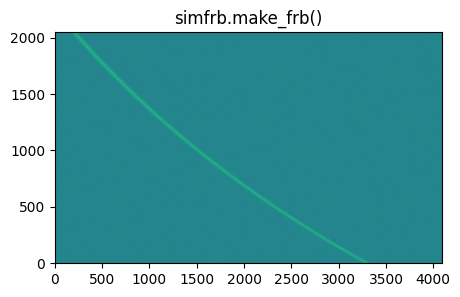

In [4]:
# dm = 221
fmin, fmax = 1300e6, 1650e6 # [Hz]
frb = make_frb(f_min=fmin, f_max=fmax, t0=0.01*2)
# make_frb?

nspec, nchans = frb.shape
print(frb.shape)

freqs = np.linspace(fmin, fmax, nchans) # [Hz]
times = np.arange(nspec)*1e-4 # [s]
maxdm = 500

plt.figure(figsize=(5,3))
plt.imshow(frb.T, aspect='auto', origin='lower')
plt.title('simfrb.make_frb()')
plt.show()

In [5]:
fdmt_sim = FDMT(freqs, times, maxdm)
dmt_sim = fdmt_sim.apply(frb)
print(dmt_sim.shape)
dm_sim = fdmt_sim.measure_dm(dmt_sim, maxdm)
dm_sim

(4096, 2048)


333.4147532975085

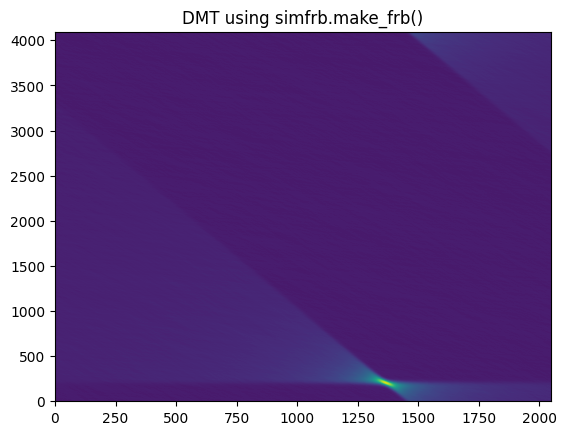

In [6]:
plt.figure()
plt.imshow(dmt_sim, aspect='auto', origin='lower')
plt.title('DMT using simfrb.make_frb()')
plt.show()

### Using a test file from PTS+RPi frequency synth

In [48]:
data_file = '../../Spectra_20221221230947.dat'

data = prepare_data(data_file)
NSPEC, NCHANS = data.shape 

FMIN, FMAX = 1410e6, 1640e6 # [Hz]
FREQS = np.linspace(FMIN, FMAX, NCHANS) # [Hz]
TIMES = np.arange(NSPEC)*1e-4 # [s]

# data.shape = data.shape[0:1] + (-1, 8)
# data = data.sum(axis=-1)
# FREQS.shape = (-1, 8)
# FREQS = FREQS.mean(axis=-1)
# # data = np.random.normal(size=data.shape)
print(data.shape, FREQS.shape)

(4096, 2048) (2048,)


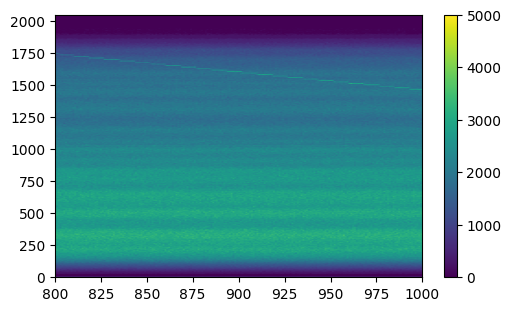

In [66]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
im = ax.imshow(data.T, aspect='auto', origin='lower')
cbar = fig.colorbar(im, pad=0.01)
im.set_clim(0, 5000)
plt.xlim(800, 1000)
plt.show()

In [50]:
# FMIN, FMAX = 1410e6, 1640e6 # [Hz]
# FREQS = np.linspace(FMIN, FMAX, NCHANS) # [Hz]

# TIMES = np.arange(NSPEC)*1e-4 # [s]

In [62]:
MAXDM = 500

fdmt = FDMT(freqs=FREQS, times=TIMES, maxDM=MAXDM)

start_time = time.time()
dmt = fdmt.apply(data)
print('FDMT execution time [s]:', time.time()-start_time) 
print('Measured DM [pc*cm^-3]:', fdmt.measure_dm(dmt, MAXDM))

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
im = ax.imshow(dmt, aspect='auto')
plt.show()

In [60]:
def OG_FDMT(Image, freqs, times, maxDM, maxDT=None, dtype='float'):
    assert (freqs.size, times.size) == Image.shape
    assert freqs.size == 2**np.around(np.log2(freqs.size))
    assert times.size == 2**np.around(np.log2(times.size))
    dt = times[1] - times[0]
    df = freqs[1] - freqs[0]
    full_dt = (freqs[0]**-2 - freqs[-1]**-2)
    maxDT = (DM_delay(maxDM, freqs[0]) - DM_delay(maxDM, freqs[-1])) / dt

    for i in range(int(np.log2(freqs.size))+1):
        delta_t = int(np.ceil(maxDT * ((freqs[0]**-2 - (freqs[0] + 2**i * df)**-2) / full_dt)))
        #print(i, delta_t)
        if i == 0:
            # State is nfreq x shifts x times
            State = np.zeros((freqs.size, delta_t+1, times.size), dtype)
            State[:,0,:] = Image  # zero bin has no shift
            for idt in range(1, delta_t+1):
                # XXX why is this State on the RHS and not Image
                State[:, idt, idt:] = State[:, idt-1, idt:] + Image[:, :-idt]
            continue
        # the maximum delta_t needed to calculate the ith iteration
        new_State = np.zeros((State.shape[0] // 2, delta_t+1, times.size), dtype)
        for ch in range(new_State.shape[0]):
            f0 = freqs[ch * 2**i]
            f2 = freqs[(ch + 1) * 2**i - 1]
            loc_dt = f0**-2 - f2**-2
            f1 = (f2 + f0) / 2
            delta_t_local = int(np.ceil(maxDT * (loc_dt / full_dt)))
            for idt in range(delta_t_local+1):
                dT1 = int(round(idt * (f0**-2 - f1**-2) / loc_dt))
                new_State[ch, idt] = State[2*ch, dT1]
                new_State[ch, idt, dT1:] += State[2*ch+1, idt - dT1, :times.size-dT1]
        State = new_State
    return State[0]

In [68]:
start_time = time.time()
og_dmt = OG_FDMT(data.T, FREQS, TIMES, MAXDM)
print('OG_FDMT execution time [s]:', time.time()-start_time) 

t0, dm0 = inds = np.unravel_index(np.argmax(og_dmt, axis=None), og_dmt.shape)
dm = np.linspace(0, MAXDM, og_dmt.shape[1])[dm0]
print('Measured DM [pc*cm^-3]:', dm)

OG_FDMT execution time [s]: 1.093790054321289
Measured DM [pc*cm^-3]: 463.4920634920635


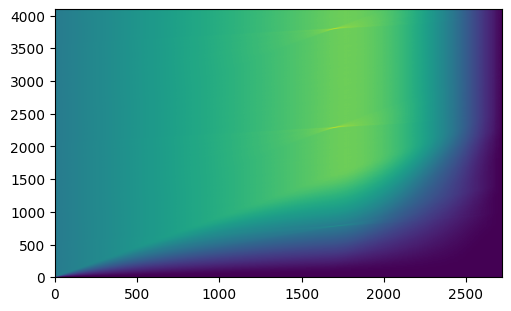

In [70]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
im = ax.imshow(og_dmt.T, aspect='auto', origin='lower')
plt.show()